In [1]:
import argparse
import builtins
import math
import os
import random
import shutil
import time
import warnings
import sys
sys.path.append("/opt/tiger/moco")
import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import multiprocessing

In [2]:
checkpoint = torch.load("/mnt/bn/data-tns-live-llm/leon/experiments/llm/face/trained_model_2m/checkpoint_0010.pth.tar")

In [3]:
print(checkpoint.keys())
# print(checkpoint["state_dict"].keys())

dict_keys(['epoch', 'arch', 'state_dict', 'optimizer'])


In [3]:
import torch.nn as nn
import torchvision.models as models
class ResNetSimCLR(nn.Module):
    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        model = self.resnet_dict[model_name]
        return model

    def forward(self, x):
        return self.backbone(x)


In [4]:
from torchvision.models.resnet import resnet50, ResNet
from torch.nn.parallel import DataParallel
model = ResNetSimCLR(base_model="resnet50", out_dim=128).cuda()

/home/tiger/miniconda3/envs/leon/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tiger/miniconda3/envs/leon/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [71]:
model = resnet50(num_classes=128)

In [6]:
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [5]:
def clean_state_dict(state_dict, prefix='module.'):
    """
    去掉state_dict中的指定前缀。
    """
    keys = sorted([key for key in state_dict if key.startswith(prefix)])
    for key in keys:
        state_dict[key.replace(prefix, '')] = state_dict[key]
        del state_dict[key]
    return state_dict

In [6]:
state_dict = clean_state_dict(checkpoint["state_dict"],"module.encoder_q.")
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [7]:
model = model.cuda()

In [34]:
# 确保model能在多GPU上运行
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = DataParallel(model)
model = model.cuda()  # 将模型移到GPU上

Using 8 GPUs


In [58]:
path = os.listdir("/mnt/bn/data-tns-live-llm/leon/experiments/llm/face/cropped_second_stage_imgs_2million/")[:10000]
print(len(path))

10000


In [57]:
# from torchvision.transforms import ToTensor
# to_tensor = ToTensor()
# normalize = transforms.Normalize(
#     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
# )
# transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# def get_embedding(img):
#     # 确保输入也被转移到GPU上
#     img_gpu = transform(img).cuda().unsqueeze(0)
#     with torch.no_grad():  # 禁用梯度计算以节省内存
#         q = model(img_gpu)
#     q = F.normalize(q, dim=1)
#     return q.cpu()  # 将结果送回CPU以节省GPU内存

In [8]:
root = "/mnt/bn/data-tns-live-llm/leon/experiments/llm/face/cropped_second_stage_imgs_2million/"
img_paths = os.listdir(root)

In [9]:
import cv2 as cv
from PIL import Image
from torchvision.transforms import ToTensor

In [10]:
imgs = []
for i, path in enumerate(img_paths):
    for object_id in os.listdir(os.path.join(root,path)):
        for img in os.listdir(os.path.join(root,path,object_id)):
            imgs.append(Image.open(os.path.join(root,path,object_id,img)))
    if i==2: break

In [11]:
print(len(imgs))

40


In [64]:
imgs.append(Image.open("/mnt/bn/data-tns-live-llm/leon/experiments/llm/face/cropped_test_imgs/7365046803467291397/5bdea8a7-80cc-4e2b-86f7-7a1772eaf485.jpg"))

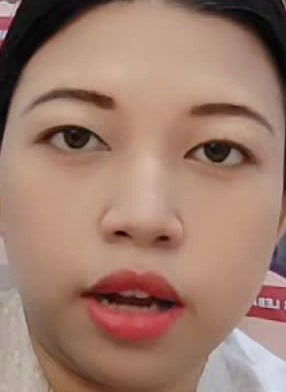

In [12]:
from PIL import Image
imgs[1].show()

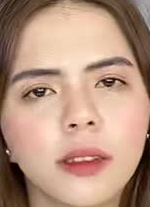

In [13]:
imgs[21].show()

In [ ]:
imgs = []
for i in (0,11,21,31):
    imgs.append()

In [16]:
emb1 = get_embedding(imgs[0])
emb2 = get_embedding(imgs[11])
emb3 = get_embedding(imgs[21])
emb4 = get_embedding(imgs[31])

In [55]:
print(emb1.shape)

torch.Size([1, 128])


In [17]:
tmp = torch.cat([emb1,emb2,emb3,emb4])

In [18]:
print(torch.matmul(tmp, tmp.T))

tensor([[1.0000, 0.9994, 0.9823, 0.9823],
        [0.9994, 1.0000, 0.9823, 0.9823],
        [0.9823, 0.9823, 1.0000, 1.0000],
        [0.9823, 0.9823, 1.0000, 1.0000]])


In [78]:
s = emb1 @ emb2.T
print(s)

tensor([[0.9994]])


# 构建检索数据集

In [15]:
import os
import random
import glob
from collections import defaultdict
from PIL import Image
import torch
from torchvision import transforms
from torch.nn import functional as F
import copy
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from torch.utils.data import Dataset, DataLoader

# 已经定义的转换器
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
resize = transforms.Resize((224,224))
transform = transforms.Compose([
        transforms.ToTensor(),
        resize, 
        normalize
        ])

def get_embedding(img):
    # 确保输入也被转移到GPU上
    img_gpu = transform(img).cuda().unsqueeze(0)
    with torch.no_grad():  # 禁用梯度计算以节省内存
        q = model(img_gpu)
    q = F.normalize(q, dim=1)
    return q.cpu()  # 将结果送回CPU以节省GPU内存

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        folder_name, img_name = image_path.split("/")[-2], image_path.split("/")[-1]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, folder_name, img_name

def folder_selection(root_path):
    """计算符合条件的图片的嵌入，并为每个符合条件的文件夹随机选择两张图片"""
    selected_pairs = defaultdict(list)
    
    for folder in os.listdir(root_path)[200:300]:
        folder_path = os.path.join(root_path, folder)
        if os.path.isdir(folder_path):
            images = glob.glob(os.path.join(folder_path, '*.jpg'))
            if len(images) >= 2:
                selected_pairs[folder].extend(images)
    return selected_pairs

def get_selected_embeddings_parallel(selected_pairs, dataloader, model=model, transform=transform):
    embeddings_dict = {}
    with torch.no_grad():
        for images, folder_names, img_names in tqdm(dataloader):
            images = images.cuda()
            outputs = model(images)
            embeddings = F.normalize(outputs, dim=1)
            embeddings = embeddings.cpu()

            for img, folder_name, img_name, emb in zip(images, folder_names, img_names, embeddings):
                identifier = (folder_name, os.path.basename(img_name)[:-4])
                embeddings_dict[identifier] = emb
        torch.cuda.empty_cache()
    return embeddings_dict

def get_selected_embeddings(selected_pairs):
    embeddings_dict = {}
    for folder, images in tqdm(selected_pairs.items()):
        # 从每个符合条件的文件夹中随机选择两张图片
        img_k_path, img_v_path = random.sample(images, 2)
        img_k = Image.open(img_k_path)
        img_v = Image.open(img_v_path)
        embeddings_dict[(folder, os.path.basename(img_k_path)[:-4])] = get_embedding(img_k)  # 存储img_k的嵌入
        embeddings_dict[(folder, os.path.basename(img_v_path)[:-4])] = get_embedding(img_v)  # 存储img_v的嵌入
        torch.cuda.empty_cache()
    return embeddings_dict

def evaluate_retrieval(embeddings_dict):
    total_correct = 0
    total_trials = len(embeddings_dict)  # 因为每个文件夹贡献了两次检索尝试
    for folder, _ in tqdm(embeddings_dict):
        query_embeddings = [emb.unsqueeze(0) for (k, emb) in embeddings_dict.items() if k[0] == folder] # 0用于做key
        gallery_embeddings = [emb.unsqueeze(0) for (k, emb) in embeddings_dict.items() if k[0] != folder]
        gallery_embeddings = torch.cat([query_embeddings[1], torch.cat(gallery_embeddings, dim=0)], dim=0)
        similarities = F.cosine_similarity(query_embeddings[0], gallery_embeddings, dim=-1)
        similarities = similarities.view(-1)  # 展平相似度矩阵以便于后续处理
        _, sorted_indices = similarities.sort(descending=True)
        if 0 in sorted_indices[:10]: total_correct += 1

    print(total_trials)
    print(total_correct)
    accuracy = total_correct / total_trials if total_trials > 0 else 0
    print(f"检索准确率: {accuracy:.2f}")

In [60]:
# 主程序
root_path = '/mnt/bn/data-tns-live-llm/leon/experiments/llm/face/cropped_second_stage_imgs_2million/'
selected_pairs = folder_selection(root_path)

In [61]:
print(len(list(selected_pairs.keys())))

0


In [35]:
image_paths = [os.path.join(folder_path, img_name) for folder_path, images in selected_pairs.items() for img_name in images]
dataset = ImageDataset(image_paths, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [9]:
import random
# 随机选择100个键
random_keys = random.sample(list(selected_pairs.keys()), 100)
# 创建一个新的字典，包含随机选择的键值对
tmp = {k: selected_pairs[k] for k in random_keys}

In [ ]:
embeddings_dict = get_selected_embeddings(selected_pairs)

In [27]:
import random
# 随机选择100个键
random_keys = random.sample(list(embeddings_dict.keys()), 100)
# 创建一个新的字典，包含随机选择的键值对
tmp = {k: embeddings_dict[k] for k in random_keys}

In [38]:
gallery_embeddings = torch.cat([emb for (k, emb) in embeddings_dict.items()]).cuda()
print(gallery_embeddings.shape)
similarity_matrix = torch.matmul(gallery_embeddings, gallery_embeddings.T).cpu()

torch.Size([138, 128])


In [41]:
import torch
# 初始化一个计数器，用于记录top-5的比例
top5_same_person_count = 0

# 遍历每一行（每个向量）
for i in range(similarity_matrix.size(0)):
    if i%2!=0: continue
    # 获取当前向量与其他向量的相似度以及对应的索引
    _, sorted_indices = torch.sort(similarity_matrix[i], descending=True)
    same_person_index = (i + 1)
    
    # 如果相同人的另一张脸的索引在top-5中，则增加计数器
    if same_person_index in sorted_indices[:50]:
        top5_same_person_count += 1

# 计算比例
total_count = similarity_matrix.size(0)  # 总的向量数量
proportion = top5_same_person_count / total_count

print(f"Top-5 相同人脸的比例: {proportion:.2f}")

Top-5 相同人脸的比例: 0.48


In [41]:
import plotly.express as px
# 使用Plotly Express创建交互式热力图
fig = px.imshow(similarity_matrix.numpy(),  # 确保tensor_sample是numpy数组
                 color_continuous_scale='Viridis',  # 颜色映射表
                 aspect='equal')  # 保持纵横比

# 添加标题
fig.update_layout(title_text='Interactive Heatmap Visualization')
fig.update_layout(width=700, height=700)
# 显示图表
fig.show()

In [59]:
evaluate_retrieval(embeddings_dict)

100%|██████████| 128/128 [00:00<00:00, 2249.72it/s]

128
118
检索准确率: 0.92


In [1]:
import os
path = os.listdir("/mnt/bn/data-tns-live-llm/leon/experiments/llm/face/cropped_second_stage_imgs_2million")
print(len(path))

393114
